## MSDS Deep Learning Week 6: Final Assignment
#### This is the final projct for MSDA Deep Learning course.

#### In this project, we are going to create a model that predicts and detects infectious viral disease Malaria.
##### Malaria is caused by single-celled microorganisms of the Plasmodium group. It is spread exclusively through bites of infected Anopheles mosquitoes.

Malaria is a mosquito-borne infectious disease that affects humans and other animals. Malaria causes symptoms that typically include fever, tiredness, vomiting, and headaches. In severe cases, it can cause jaundice, seizures, coma, or death. Symptoms usually begin ten to fifteen days after being bitten by an infected mosquito. If not properly treated, people may have recurrences of the disease months later. In those who have recently survived an infection, reinfection usually causes milder symptoms. This partial resistance disappears over months to years if the person has no continuing exposure to malaria.

##### Life Cycle of Malaria  
 <img src="https://upload.wikimedia.org/wikipedia/commons/2/24/Life_Cycle_of_the_Malaria_Parasite.svg" width="700" />
 
 
 ##### Detecting Malaria
  <img src="https://upload.wikimedia.org/wikipedia/commons/d/dd/Plasmodium_knowlesi_smears_IDC.png" width="700" />

## 1. Library Imports and Dataset

In [31]:
pip install mlxtend

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install seaborn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [33]:
import sys
import os
import argparse

import time
import datetime
import random
import numpy as np 
import pandas as pd

import shutil
from glob import glob
from tqdm import tqdm
import gc

import re

from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.svm import LinearSVC, SVC

from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

from keras.preprocessing.image import ImageDataGenerator
import keras
from keras import models
from keras.models import Model
from keras.models import Sequential
from keras import applications

from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
### from keras.layers.pooling import _GlobalPooling1D

from keras.applications.xception import Xception
##from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge

from keras.applications.nasnet import preprocess_input

from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

import cv2
from PIL import Image
from IPython.display import display

%matplotlib inline

# Input data
print(os.listdir("../input/cell-images-for-detecting-malaria"))

['cell_images']


## 2. Data Import

In [34]:
input_directory = r"/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"
output_directory = r"/kaggle/output/"


training_dir = input_directory


if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "/kaggle/output//figures"



if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

## 3. Visualization

Uninfected


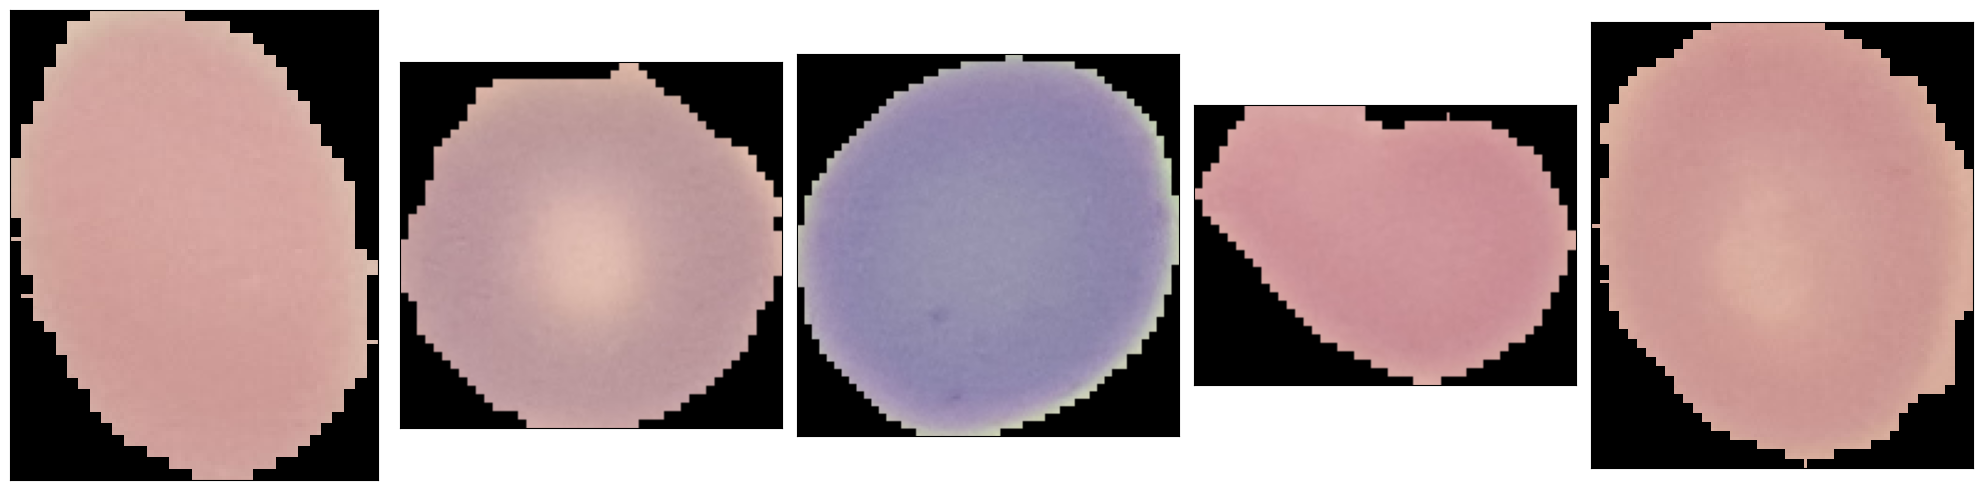

Parasitized


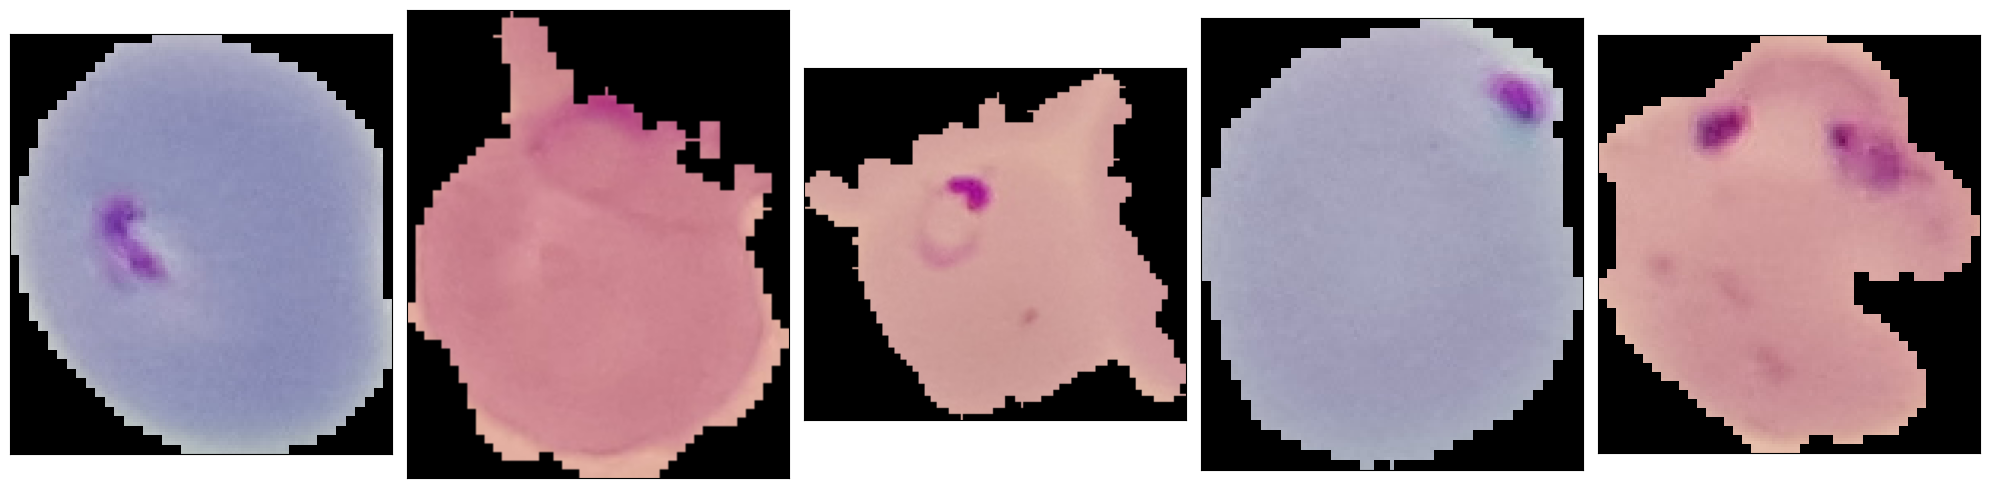

In [35]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

def plot_image(file, directory=None, sub=False, aspect=None):
    path = directory + file
    
    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_dir(directory=training_dir, count=5):
    selected_files = random.sample(os.listdir(directory), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, directory, aspect=None)

        i=i+1
    
    plt.tight_layout()
    plt.show()
    
def plot_img_dir_main(directory=training_dir, count=5):
    labels = os.listdir(directory)
    for label in labels:
        print(label)
        plot_img_dir(directory=directory+"/"+label+"/", count=count)
        
plot_img_dir_main(directory=training_dir, count=5)        

## 4. EDA and Preprocessing

In [36]:
def get_data(batch_size=32, target_size=(299, 299), class_mode="categorical", training_dir=training_dir, testing_dir=None):
        
    rescale = 1.0/255

    train_batch_size = batch_size
    test_batch_size = batch_size
    
    train_shuffle = True
    val_shuffle = True
    test_shuffle = False
    
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=45,
        shear_range=16,
        rescale=rescale,
        validation_split=0.25)

    train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=batch_size, 
        shuffle=True, 
        seed=42,
        subset='training')
    
    validation_generator = train_datagen.flow_from_directory(
        training_dir, 
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=1024, 
        shuffle=True, 
        seed=42,
        subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=rescale)
    
    test_generator = None
    
    
    class_weights = get_weight(train_generator.classes)
    
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)
    
    
    
    return train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps


def get_weight(y):
    class_weight_current =  cw.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    return class_weight_current
    

## 5. Modeling

In [37]:
def get_model(model_name, input_shape=(96, 96, 3), num_class=2):
    inputs = Input(input_shape)
    
    if model_name == "Xception":
        base_model = Xception(include_top=False, input_shape=input_shape)
    #elif model_name == "ResNet50":
     #   base_model = ResNet50(include_top=False, input_shape=input_shape)
    elif model_name == "InceptionV3":
        # base_model = InceptionV3(include_top=False, input_shape=input_shape)
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == "InceptionResNetV2":
        base_model = InceptionResNetV2(include_top=False, input_shape=input_shape)
    if model_name == "DenseNet201":
        base_model = DenseNet201(include_top=False, input_shape=input_shape)
    if model_name == "NASNetMobile":
        base_model = NASNetMobile(include_top=False, input_shape=input_shape)
    if model_name == "NASNetLarge":
        base_model = NASNetLarge(include_top=False, input_shape=input_shape)


    x = base_model(inputs)
    
    output1 = GlobalMaxPooling2D()(x)
    output2 = GlobalAveragePooling2D()(x)
    output3 = Flatten()(x)
    
    outputs = Concatenate(axis=-1)([output1, output2, output3])
    
    outputs = Dropout(0.5)(outputs)
    outputs = BatchNormalization()(outputs)
    
    if num_class>1:
        outputs = Dense(num_class, activation="softmax")(outputs)
    else:
        outputs = Dense(1, activation="sigmoid")(outputs)
        
    model = Model(inputs, outputs)
    
    model.summary()
    
    
    return model

# Custom Convolutional Neural Network 
def get_conv_model(num_class=2, input_shape=(3,150,150)):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=input_shape))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(num_class , activation='softmax'))

    print(model.summary())
    
    return model


In [38]:
main_model_dir = output_directory + r"/kaggle/output/models/"
main_log_dir = output_directory + r"/kaggle/output/logs/"

try:
    os.mkdir(main_model_dir)
except:
    print("Could not create main model directory")
    
try:
    os.mkdir(main_log_dir)
except:
    print("Could not create main log directory")



model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')


try:
    os.mkdir(model_dir)
except:
    print("Could not create model directory")
    
try:
    os.mkdir(log_dir)
except:
    print("Could not create log directory")
    
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

Could not create main model directory
Could not create main log directory


In [39]:

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=1,
    verbose=1)

callbacks = [reduce_lr, early_stopping, checkpoint]

callbacks = [checkpoint, reduce_lr, early_stopping]



## 6. Final Model

In [40]:

# input_shape = (96, 96, 3)
input_shape = (224, 224, 3)

num_class = 2


model = get_model(model_name="NASNetMobile", input_shape=input_shape, num_class=num_class)
# model = get_conv_model(input_shape=input_shape)



Getting Base Model Timestamp: 2023-06-01 15:31:35
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 NASNet (Functional)            (None, 7, 7, 1056)   4269716     ['input_5[0][0]']                
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 1056)        0           ['NASNet[0][0]']                 
 MaxPooling2D)                                                                                    
                                          

In [41]:
loss = 'categorical_crossentropy'
# loss = 'binary_crossentropy'
metrics = ['acc']
# metrics = [auroc]

In [42]:
# batch_size = 32
batch_size = 176

class_mode = "categorical"
#class_mode = "binary"

# target_size=(96, 96)
target_size=(224, 224)

train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size, target_size=target_size, class_mode=class_mode)

Found 20670 images belonging to 2 classes.
Found 6888 images belonging to 2 classes.


## 7. Train the Model

In [43]:
print("Starting Training ...\n")

start_time = time.time()
print(date_time(1))

# batch_size = 32
# train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size)

print("\n\nCompiling Model ...\n")
learning_rate = 0.00001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# steps_per_epoch = 180
# validation_steps = 40

verbose = 1
epochs = 21

print("Training Model ...\n")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps) 
   # class_weight=1)

#elapsed_time = time.time() - start_time
#elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

#print("\nElapsed Time: " + elapsed_time)
#print("Completed Model Training", date_time(1))

Starting Training ...

Timestamp: 2023-06-01 15:31:45


Compiling Model ...

Training Model ...

Epoch 1/21
118/118 [==============================] - 788s 6s/step - loss: 0.5863 - acc: 0.7303 - val_loss: 0.4960 - val_acc: 0.7642 - lr: 1.0000e-05
Epoch 2/21
118/118 [==============================] - 736s 6s/step - loss: 0.2824 - acc: 0.8915 - val_loss: 0.3911 - val_acc: 0.8367 - lr: 1.0000e-05
Epoch 3/21
118/118 [==============================] - 735s 6s/step - loss: 0.2057 - acc: 0.9322 - val_loss: 0.3504 - val_acc: 0.8643 - lr: 1.0000e-05
Epoch 4/21
118/118 [==============================] - ETA: 0s - loss: 0.1914 - acc: 0.9380
Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.
118/118 [==============================] - 730s 6s/step - loss: 0.1914 - acc: 0.9380 - val_loss: 0.3651 - val_acc: 0.8595 - lr: 1.0000e-05
Epoch 5/21
118/118 [==============================] - ETA: 0s - loss: 0.1747 - acc: 0.9446
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.5

## 8. Model Performance

In [44]:
def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    ylim_pad = [0.005, 0.005]



    plt.figure(figsize=(20, 5))

    

    y1 = history.history['acc']
    y2 = history.history['val_acc']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()


    

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

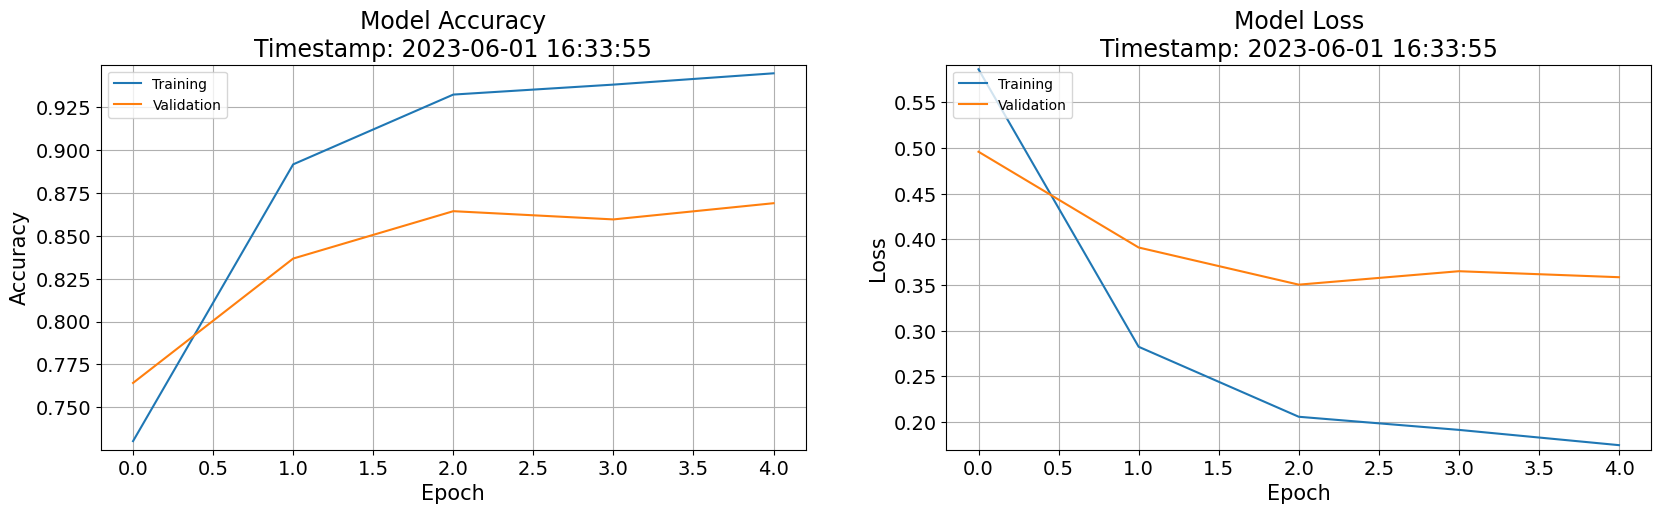

In [45]:
plot_performance(history=history)

## 9.Conclusion

Model accuracy stabilizes after few epochs and so is validation accuracy

As we can see from the above results that to train on few models, we are getting a accuracy of ~92%